# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

from sklearn.cluster import KMeans as KMeans_SL
from sklearn.datasets import fetch_openml, make_moons, make_circles, make_classification
from sklearn.decomposition import PCA as PCA_SL
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_samples
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics

# Определение функций и классов

## Определение функции генерации данных

In [2]:
def create_elipsoid_data(C1=0, C2=0, # координаты центра
                         S1=5, S2=1, # радиусы эллипса
                         theta=45, # угол наклона
                         N=250, # число точек
                         random_state=42): # фиксируем "случайность"
    
    np.random.seed(random_state)
    
    theta = np.pi*theta/180
    Centers = np.array([C1,C2])
    Sigmas = np.array([S1,S2])

    R = np.array([[np.cos(theta), - np.sin(theta)],
                [np.sin(theta), np.cos(theta)]]) 

    return (R @ np.diag(Sigmas) @ np.random.randn(2, N)+np.diag(Centers) @ np.ones((2, N))).T

In [3]:
def make_binary_clf(N, method='line', noises=0.15, random_state=42):
    if random_state: rng = np.random.RandomState(seed = random_state)
    
    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, n_features=2,
                                   n_redundant=0, n_informative=2,
                                   n_clusters_per_class=1, class_sep=2,
                                   random_state=random_state)
        X += np.random.randn(*X.shape) * noises
        out = (X, y)
    
    elif method == 'moons':
        X, y = make_moons(n_samples=N, noise=noises, 
                          random_state=random_state)
    
    elif method == 'circles':    
        X, y = make_circles(n_samples=N, noise=noises, factor=0.5,
                            random_state=random_state )

    return X, y

#---------------------------------
def plot_data(ax, ds,name='', marker='o', colors=("#FF0000", '#0000FF'), alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)

    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker=marker, c=y,
                   cmap=cm_bright,s=s,
                   alpha=alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker=marker, c=y,
                   cmap=cm_bright,s=s,
                   facecolor='None',
                   alpha=alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

## Определение функции визуализациии данных

In [4]:
def plot_pca(X, Y, figsize=(10, 7), alpha=0.5, s=196, c='green', edgecolor='red', xlabel='', ylabel=''):
    fig = plt.figure(figsize=figsize)

    plt.scatter(
        X,
        Y,
        alpha=alpha,
        s=s,
        c=c,
        edgecolor=edgecolor
    );

    plt.grid()
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.xlim((-15, 15))
    plt.ylim((-15, 15));

## Определение функции визуализации пространства главных компонент

In [5]:
def plot_multi(data, y,  names):
    axis = [[0,1],
            [2,1],
            [0,3],
            [2,3],]

    labels = [['',names[1]],
            ['',''],
            [names[0],names[3]],
            [names[2],'']]

    fig, sub = plt.subplots(2, 2, figsize = (11,11))

    for n, (axi, label, ax) in enumerate(zip(axis,  labels, sub.flatten())):
        scatter = ax.scatter(data[:,axi[0]],data[:,axi[1]],
                             c=y, s = 36, cmap = 'tab10',
                             alpha = 0.7, facecolors = 'none' );
        ax.set_ylabel(label[1], fontsize = 20)
        ax.set_xlabel(label[0], fontsize = 20)
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)     
        ax.grid()
        ax.set_xlim([-10, 12])
        ax.set_ylim([-8, 8])

        legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Цифры", fontsize=15)
        ax.add_artist(legend1)

## Определение функции визуализации кластеров

In [6]:
def plot_cluster(X,centroids, cluster_label, centroids_label, old_centroids=None, old_centroids_label=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)

    plt.scatter(X[:, 0], X[:, 1], c=cluster_label, cmap='bwr', s=100, alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], c=centroids_label, cmap='bwr', s=400, edgecolors='k')
    
    if old_centroids is not None:
        plt.scatter(old_centroids[:, 0], old_centroids[:, 1], c=old_centroids_label, cmap= 'bwr', s=200, edgecolors='k')  

    plt.xticks([])
    plt.yticks([])

## Определение функции визуализации весов

In [7]:
def weights_vis(B, B0, features_names):
    numbers = np.arange(0,len(features_names)+1)
    Bs = np.hstack([B0,B])
    tick_labels = ['B'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(Bs):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = Bs, color = cc)
    plt.xticks(np.arange(0,len(features_names)+1),np.hstack(['b0', features_names]),rotation = 45 );

## Определение функции вычисления расстояния

In [8]:
def distance(X1, X2, metric = 'euclidean', p = 2):
    if metric == 'euclidean':
        dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
    if metric == 'cityblock':
        dist = np.sum(np.abs(X1 - X2).T,axis=0)
    if metric == 'Chebyshev':
        dist = np.max(np.abs(X1 - X2).T,axis=0)  
    if metric == 'Minkowski':
        dist = np.power(np.sum(np.power(np.abs(X1 - X2),p).T,axis=0),1/p)      
    return dist

## Определение класса PCA

In [9]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.values = None
        self.mean = None
    
    #--------------------------------    
    def fit(self, X):

        self.mean = np.mean(X, axis=0)
        
        # Считаем матрицу ковариации
        cov_matrix = np.cov(X - self.mean, rowvar = False)
        
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        idx = eigenvalues.argsort()[::-1] #Сортируем по возрастанию
        
        # Берём первые n главных компонент
        self.components = eigenvectors[:, idx][:, :self.n_components]
        self.values     = eigenvalues[idx]
        
        return self
    
    #--------------------------------
    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.components)

    #--------------------------------
    def fit_transform(self, X):
        return self.fit(X).transform(X)

    #--------------------------------
    def inverse_transform(self, X_new):
        return np.dot(X_new, self.components.T) + self.mean

    #--------------------------------
    def score(self, X):
        SStot = np.sum(np.square(X - np.mean(X)))
        SSres = np.sum(np.square(X - self.inverse_transform(self.fit_transform(X))))
        return 1 - SSres/SStot

    #--------------------------------
    def plot_eigvalues(self, figsize=(15,7)):
        plt.figure(figsize=figsize)
        plt.plot(self.values,'.',
                 label='Все собственные значения',
                 linewidth = 3)
        plt.plot(self.values[:self.n_components],'r-o',
                 label='Собственное Пространство',
                 markersize = 10, mfc='none',
                 linewidth = 2, alpha = 0.8)
        plt.ylabel('собственные\n значения', fontsize=25)
        plt.grid();
        plt.legend(fontsize=25);
        plt.xticks(fontsize = 25); plt.yticks(fontsize = 25);
        plt.tight_layout();

## Определение класса KMeans

In [10]:
class KMeans():
    def __init__(self,n_clusters = 2, centroids = None,
                 max_iter=10, tol=0.01,
                 metric = 'euclidean', p = 2,
                 random_state = None):
        self.n_clusters = n_clusters
        self.centroids  = centroids
        self.max_iter   = max_iter        
        self.tol        = tol
        self.iters      = None
        self.inertia = None
        self.metric = metric
        self.p  = p
        self.random_state  = random_state

    #-------------------------------------    
    def distance(self, X1, X2):
        if self.metric == 'euclidean':
            dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
        if self.metric == 'cityblock':
            dist = np.sum(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Chebyshev':
            dist = np.max(np.abs(X1 - X2).T,axis=0)  
        if self.metric == 'Minkowski':
            dist = np.power(np.sum(np.power(np.abs(X1 - X2),self.p).T,axis=0),1/self.p)      
        return dist

    #-------------------------------------
    def init_centroids(self, X):
        if self.random_state: rng = np.random.seed(self.random_state)
        c_idxs = np.random.randint(0, X.shape[0], size = self.n_clusters)
        return X[c_idxs,:]

    #-------------------------------------
    def predict(self, X):
        distances = np.zeros((X.shape[0], self.n_clusters))

        for i,centr in enumerate(self.centroids):
            distances[:,i] = self.distance(centr,X)
        self.inertia = np.sum(np.power(np.min(distances,axis = 1),2))
        return np.argmin(distances,axis = 1)

    #-------------------------------------
    def transform(self,X):
        return self.predict(X)

    #-------------------------------------
    def delta_centroids(self,old_centroids):
        return (
                self.distance(self.centroids,old_centroids)/
                self.distance(old_centroids, np.mean(old_centroids))
               ).mean()

    #-------------------------------------
    def fit(self, X):
        
        if self.centroids is None:
            self.centroids = self.init_centroids(X)
    
        d_centrs = np.inf

        for i in range(self.max_iter):

            old_centroids = np.copy(self.centroids)
            
            cluster_label = self.predict(X)

            for k in range(self.n_clusters):
                
                c_idxs = np.flatnonzero(cluster_label==k)
                
                self.centroids[k] = X[c_idxs].mean(axis = 0)

            d_centrs = self.delta_centroids(old_centroids)

            self.iters = i
            if d_centrs<=self.tol:
                break
        return self

    #-------------------------------------
    def fit_transform(self, X):
        return self.fit(X).predict(X)

# Метод главных компонент

## Синтетические данные

### Генерация данных

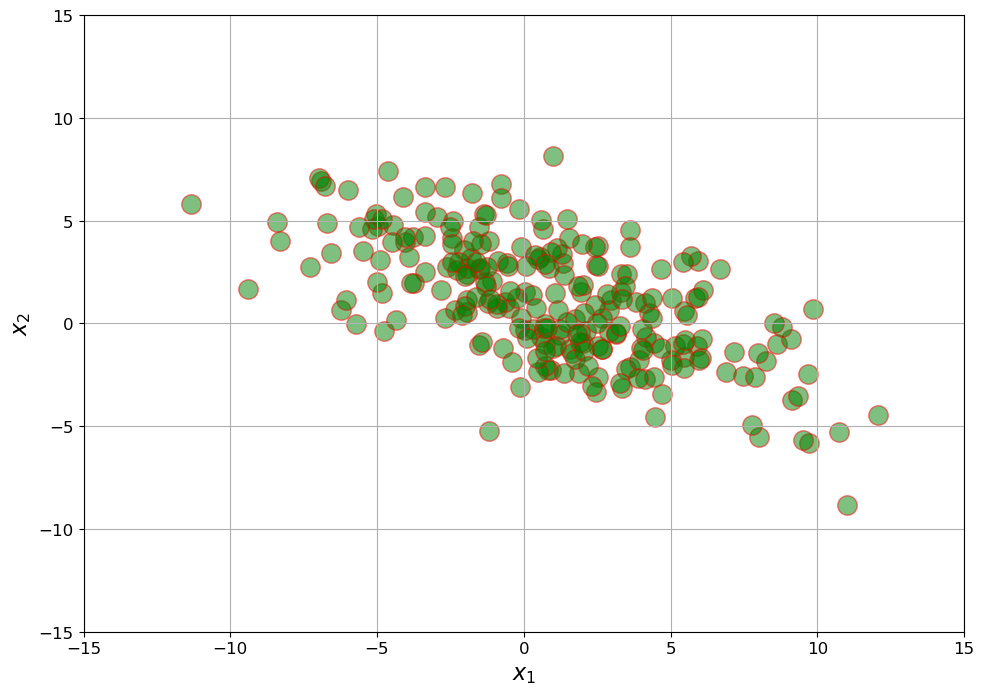

In [11]:
X = create_elipsoid_data(C1=1, C2=1, S1=5, S2=2, theta=-30, N=250, random_state=42) 

plot_pca(
    X[:, 0],
    X[:, 1],
    xlabel=r'$x_1$',
    ylabel=r'$x_2$'
)

### Применение метода главных компонент

In [12]:
pca = PCA(n_components=2)

pca.fit(X)
pca.score(X)

1.0

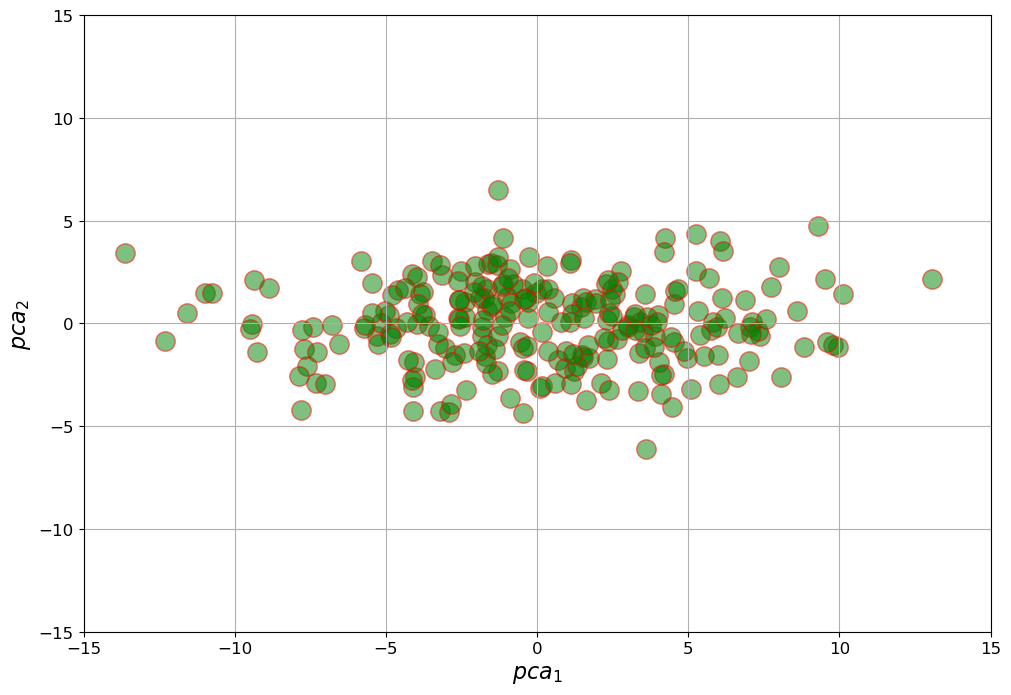

In [13]:
X_new = pca.transform(X)

plot_pca(
    X_new[:, 0],
    X_new[:, 1],
    xlabel=r'$pca_1$',
    ylabel=r'$pca_2$'
)

In [14]:
Eigen_Vectors = pca.components
Eigen_Values = pca.values

In [15]:
print('Собственные значениея: ', Eigen_Values, sep='\n')
print('-' * 30)
print('Минимальное значение: ', X_new.min(), sep='\n')
print('-' * 30)
print('Максимальное значение: ', X_new.max(), sep='\n')

Собственные значениея: 
[23.33291282  3.983184  ]
------------------------------
Минимальное значение: 
-19.295858708965202
------------------------------
Максимальное значение: 
13.068623696357012


In [16]:
print('Собственные вектора: ',  Eigen_Vectors, sep='\n')

Собственные вектора: 
[[-0.86171151 -0.50739854]
 [ 0.50739854 -0.86171151]]


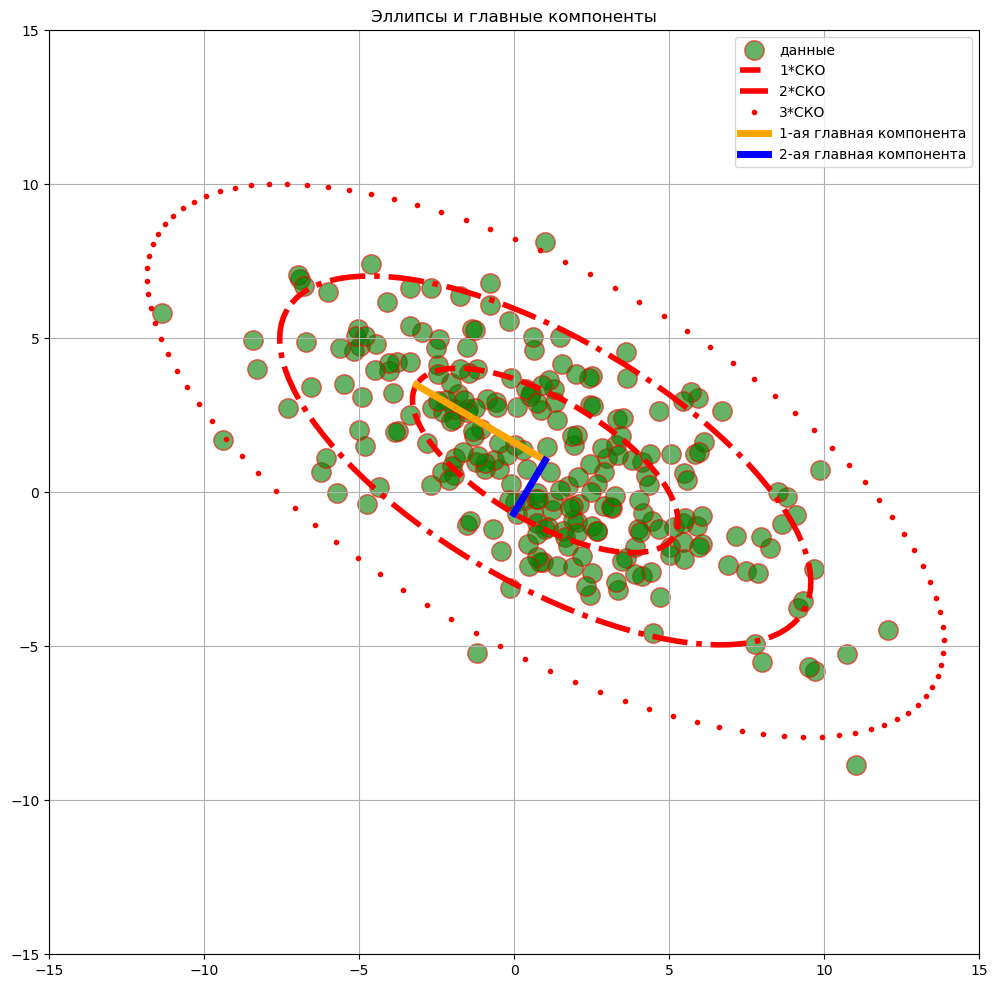

In [17]:
theta_ = 2 * np.pi * np.arange(0, 1, 0.01)

X_mean = np.mean(X, axis=0)
X_std = Eigen_Vectors @ np.diag(np.sqrt(Eigen_Values)) @ np.array([np.cos(theta_), np.sin(theta_)])

fig = plt.figure(figsize=(12, 12))

plt.scatter(X[:,0], X[:,1], alpha=0.6, label='данные', s=196, c='green', edgecolor='red')

plt.plot(X_std[0,:] + X_mean[0], X_std[1,:] + X_mean[1], '--', c='red',linewidth=4, label='1*СКО')
plt.plot(2 * X_std[0,:] + X_mean[0], 2 * X_std[1,:] + X_mean[1], '-.', c='red', linewidth=4, label='2*СКО')
plt.plot(3 * X_std[0,:] + X_mean[0], 3 * X_std[1,:] + X_mean[1], '.', c='red', linewidth=4, label='3*СКО')

plt.plot(np.array([X_mean[0], X_mean[0] + Eigen_Vectors[0, 0] * np.sqrt(Eigen_Values[0])]),
         np.array([X_mean[1], X_mean[1] + Eigen_Vectors[1, 0] * np.sqrt(Eigen_Values[0])]),
         'orange', linewidth=5, label='1-ая главная компонента')

plt.plot(np.array([X_mean[0], X_mean[0] + Eigen_Vectors[0, 1] * np.sqrt(Eigen_Values[1])]),
         np.array([X_mean[1], X_mean[1] + Eigen_Vectors[1, 1] * np.sqrt(Eigen_Values[1])]),
         'b', linewidth=5, label='2-ая главная компонента')

plt.xlim((-15, 15))
plt.ylim((-15, 15))
plt.title('Эллипсы и главные компоненты')
plt.legend()
plt.grid()

## Набор данных MNIST

## Загрузка данных

In [18]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=True)

X = X / 255.
X_ = X.values

In [19]:
display(X)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Применение метода главных компонент (10 комнонент)

In [20]:
pca10 = PCA(n_components=10)

pca10.fit(X_)
pca10.score(X_)

0.6387523030501321

In [21]:
pca_names = [str(x+1) + ' Главная Компонента' for x in range(4)]

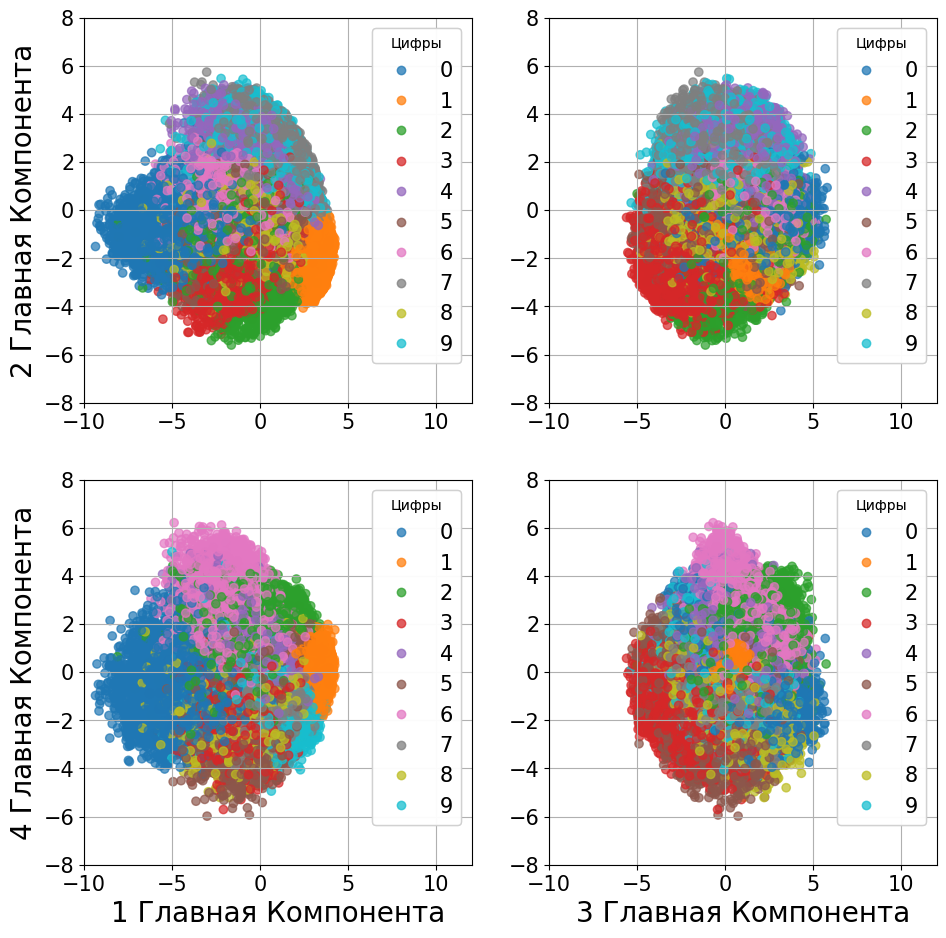

In [22]:
pca10_result = pca10.transform(X_)
pca10_inverse = pca10.inverse_transform(pca10_result)

plot_multi(pca10_result, y.astype(int), pca_names);

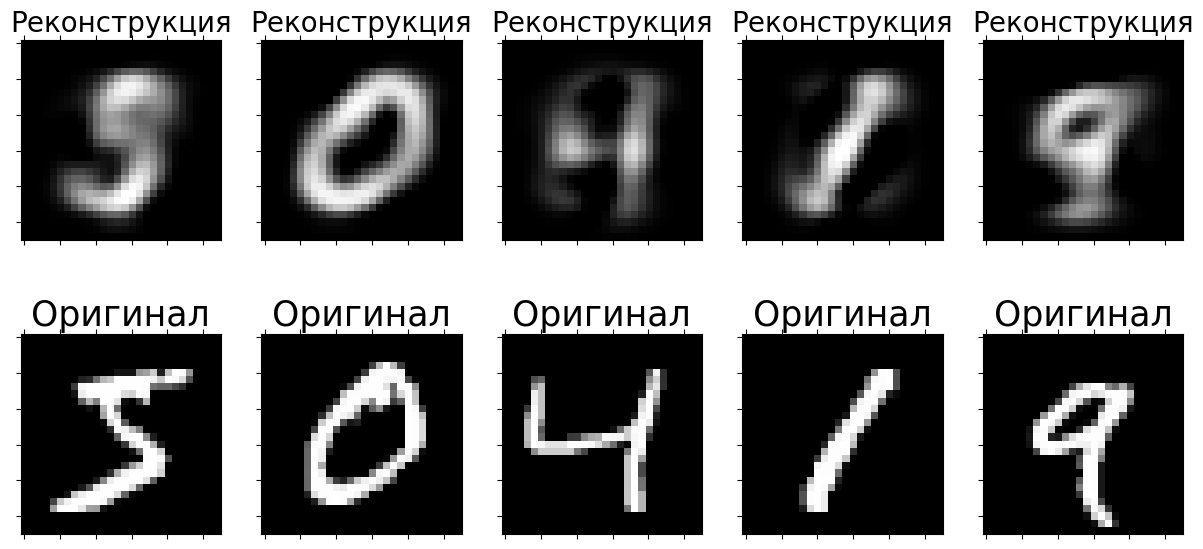

In [23]:
fig = plt.figure(figsize=(15, 7))

for i in range(0, 5):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title("Реконструкция", size=20)  
    ax.matshow(1-pca10_inverse[i,:].reshape((28, 28)).astype(float), cmap='Greys', vmin=0, vmax=1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

for i in range(0, 5):
    ax = fig.add_subplot(2, 5, i+6)
    ax.set_title("Оригинал", size=25)    
    ax.matshow(1-X_[i,:].reshape((28, 28)).astype(float), cmap='Greys', vmin=0, vmax=1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

### Применение метода главных компонент (50 комнонент)

In [24]:
pca50 = PCA(n_components=50)

pca50.fit(X_)
pca50.score(X_)

0.8765399507043385

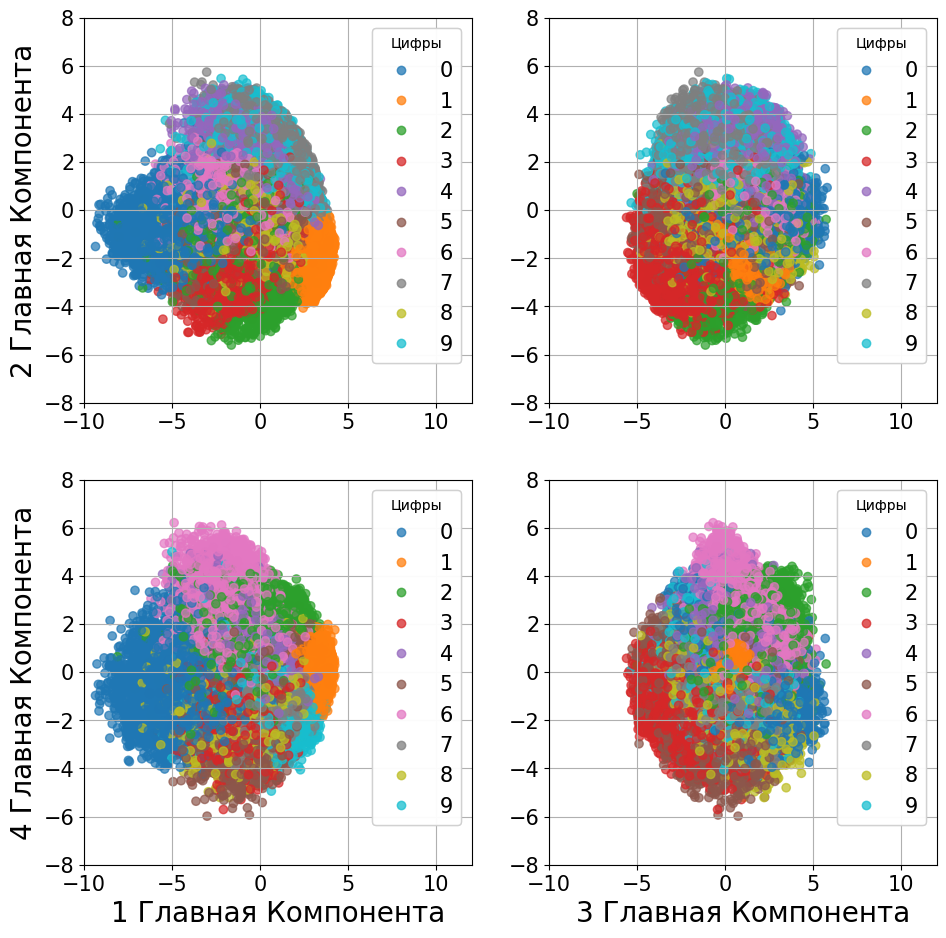

In [25]:
pca50_result = pca50.transform(X_)
pca50_inverse = pca50.inverse_transform(pca50_result)

plot_multi(pca50_result, y.astype(int), pca_names);

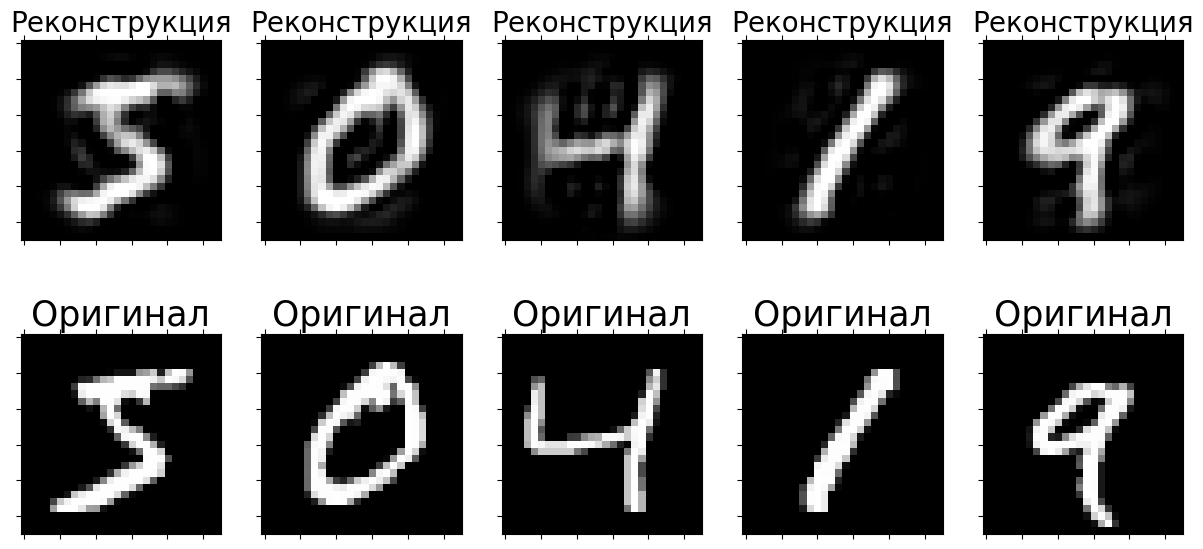

In [26]:
fig = plt.figure(figsize=(15, 7))

for i in range(0, 5):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title("Реконструкция", size=20)  
    ax.matshow(1-pca50_inverse[i,:].reshape((28, 28)).astype(float), cmap='Greys', vmin=0, vmax=1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

for i in range(0, 5):
    ax = fig.add_subplot(2, 5, i+6)
    ax.set_title("Оригинал", size=25)    
    ax.matshow(1-X_[i,:].reshape((28, 28)).astype(float), cmap='Greys', vmin=0, vmax=1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

### Применение метода главных компонент (100 комнонент)

In [27]:
pca100 = PCA(n_components=100)

pca100.fit(X_)
pca100.score(X_)

0.9398662110143557

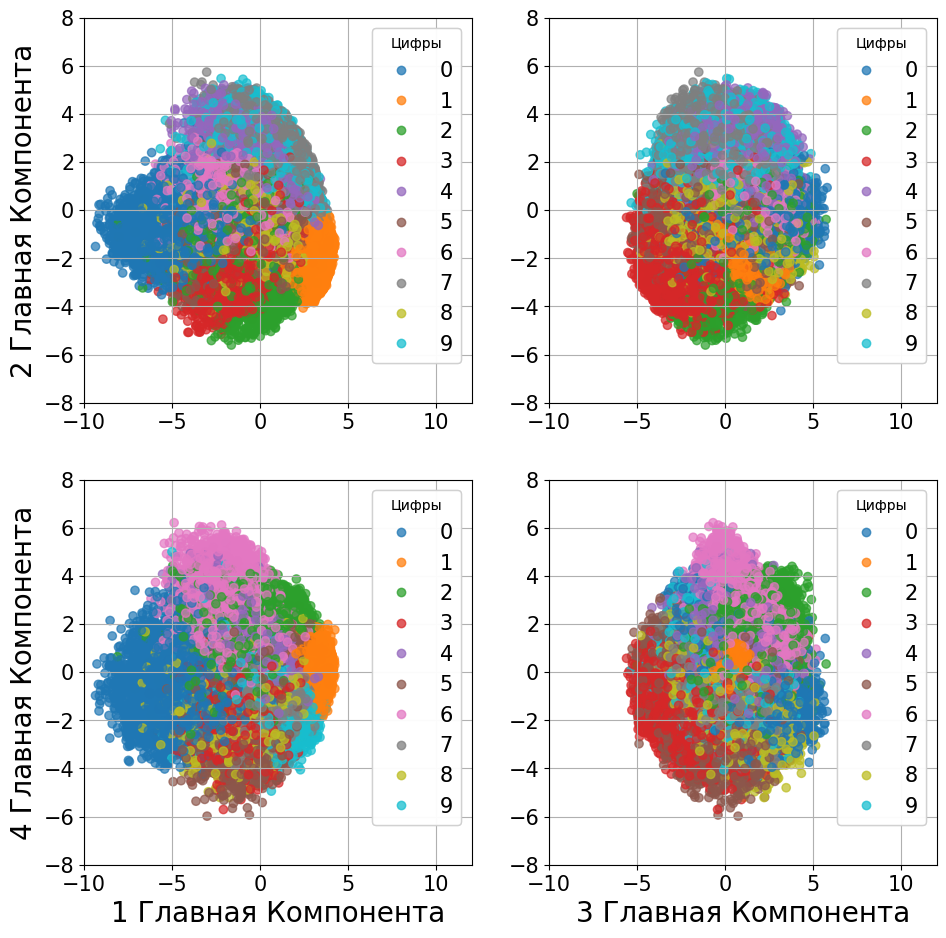

In [28]:
pca100_result = pca100.transform(X_)
pca100_inverse = pca100.inverse_transform(pca100_result)

plot_multi(pca100_result, y.astype(int), pca_names);

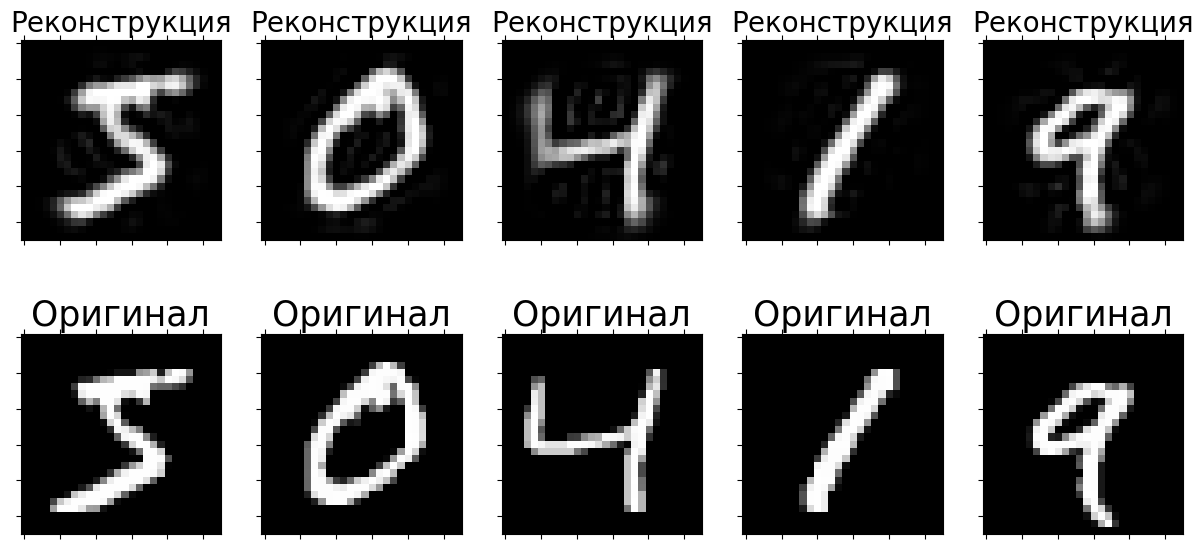

In [29]:
fig = plt.figure(figsize=(15, 7))

for i in range(0, 5):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title("Реконструкция", size=20)  
    ax.matshow(1-pca100_inverse[i,:].reshape((28, 28)).astype(float), cmap='Greys', vmin=0, vmax=1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

for i in range(0, 5):
    ax = fig.add_subplot(2, 5, i+6)
    ax.set_title("Оригинал", size=25)    
    ax.matshow(1-X_[i,:].reshape((28, 28)).astype(float), cmap='Greys', vmin=0, vmax=1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

- Исходя из рисунков выше, очевидно, что с увеличением числа компонент происходит улучшение восстановления оригинального изображения. При числе компонент равным 10 часть восстановленных изображений существенно отличается от первоначальных. Так, папример, начертание цифры "5" визуально больше соответствует цифре "9".

#### Соответствие координатам цифрам в пространстве главных компонент

- Координатам PCA-1 -7; PCA-2 0; соответствует цифра 0.
- Координатам PCA-1 4; PCA-4 1; соответствует цифра 1.
- Координатам PCA-3 0; PCA-4 5; соответствует цифра 6.
- Координатам PCA-3 -4; PCA-2 -3; соответствует цифра 3.

## Набор данных Car Moldova

### Загрузка данных

In [30]:
car_df = pd.read_csv('data/cars_moldova_data.csv', delimiter=',')

In [31]:
car_df.sample(5)

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price,Age,Km_year,Km_year_quantile,Make_model,Make_model_mean_price,Make_model_median_price
4469,Renault,Grand Scenic,2013,Minivan,144000.0,1500.0,Diesel,Automatic,8650.0,9,16000.000000,Средний пробег,Renault Grand Scenic,7177.654912,6999.0
22269,Chevrolet,Trax,2018,Crossover,33000.0,1800.0,Petrol,Automatic,13650.0,4,8250.000000,Небольшой пробег,Chevrolet Trax,13060.135593,13650.0
5582,Audi,Q5,2015,Crossover,111000.0,2000.0,Petrol,Automatic,19799.0,7,15857.142857,Средний пробег,Audi Q5,19599.115854,17999.0
34311,Nissan,X-Trail,2014,SUV,98000.0,1600.0,Diesel,Automatic,13999.0,8,12250.000000,Средний пробег,Nissan X-Trail,10818.500000,10500.0
10448,Nissan,Qashqai,2013,Crossover,186151.0,1461.0,Diesel,Manual,9050.0,9,20683.444444,Большой пробег,Nissan Qashqai,11091.779970,11600.0


### Выделим числовые и категориальные столбцы

In [32]:
def split_column_by_types(df):
    category_columns = []
    number_columns = []

    for column in df.columns:
        if df[column].dtypes == object or df[column].dtypes == 'category':
            category_columns += [column]
        else:
            number_columns += [column]
    
    return category_columns, number_columns

In [33]:
category_columns, number_columns = split_column_by_types(car_df)

print(category_columns)
print(number_columns)

['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'Km_year_quantile', 'Make_model']
['Year', 'Distance', 'Engine_capacity', 'Price', 'Age', 'Km_year', 'Make_model_mean_price', 'Make_model_median_price']


### Создадим набор данных только с числовыми признаками

In [34]:
car_df_number = car_df[number_columns].copy()
car_df_number.head(5)

,Year,Distance,Engine_capacity,Price,Age,Km_year,Make_model_mean_price,Make_model_median_price
0,2011,195000.0,1800.0,7750.0,11,17727.272727,8276.508621,7900.0
1,2014,135000.0,1500.0,8550.0,8,16875.000000,7177.654912,6999.0
2,2012,110000.0,1500.0,6550.0,10,11000.000000,4598.121951,5099.0
3,2006,200000.0,1600.0,4100.0,16,12500.000000,4488.550877,4300.0
4,2000,300000.0,2200.0,3490.0,22,13636.363636,8236.543333,7500.0


### Нормализация данных

In [35]:
car_df_number_norm = car_df_number.copy()

car_df_number_norm = car_df_number.copy()

x_min = car_df_number_norm[number_columns].min()
x_max = car_df_number_norm[number_columns].max()

car_df_number_norm[number_columns] = (car_df_number_norm[number_columns] - x_min) / (x_max - x_min)

In [36]:
car_df_number_norm.sample(5)

,Year,Distance,Engine_capacity,Price,Age,Km_year,Make_model_mean_price,Make_model_median_price
3205,0.78,0.299930,0.270833,0.031062,0.22,0.498998,0.048385,0.047431
26377,0.72,0.096910,0.250000,0.040080,0.28,0.127589,0.088015,0.087521
2225,0.62,0.243924,0.250000,0.019038,0.38,0.242485,0.018708,0.018634
24544,0.84,0.081908,0.375000,0.172846,0.16,0.180583,0.155996,0.164303
16931,0.66,0.017902,0.270833,0.014028,0.34,0.018036,0.058074,0.058707


In [37]:
car_df['Transmission'] = car_df['Transmission'].astype('category')

X = car_df_number_norm.values
y = car_df['Transmission'].cat.codes.values

### Применем метод главных компонент

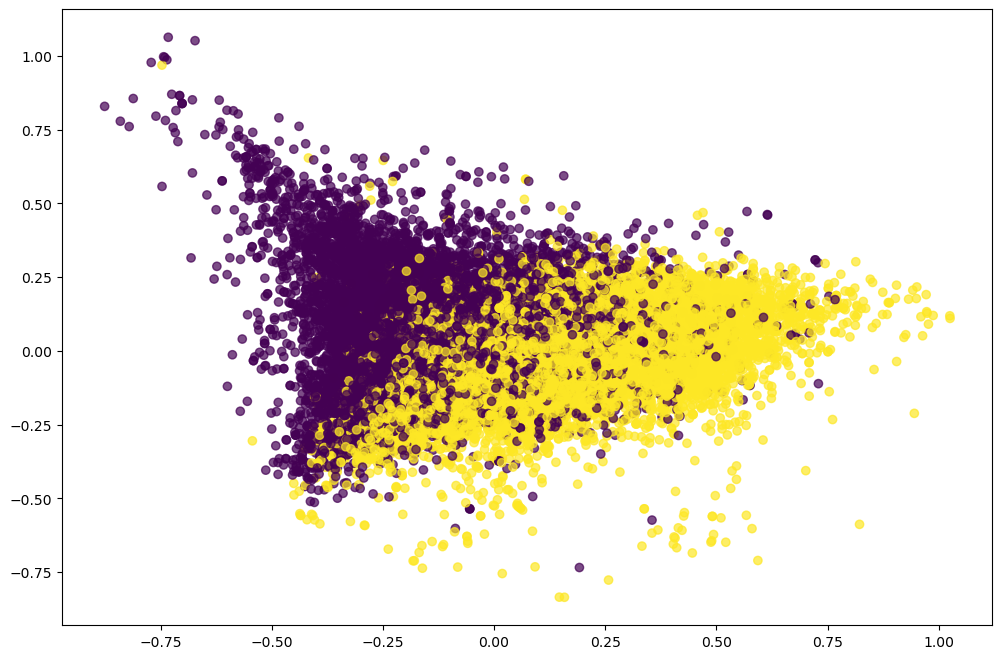

In [38]:
pca_car = PCA(n_components=4)

pca_car.fit(X)
X_transform = pca_car.transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(X_transform[:, 0], X_transform[:, 1], c=y, alpha=0.7); 
plt.show()

In [39]:
print('Собственные значения: ', pca_car.values, sep='\n')

Собственные значения: 
[ 5.32170959e-02  2.40017019e-02  2.11236181e-02  5.53424734e-03
  2.57384197e-03  1.80649735e-03  1.63603213e-04 -6.96407622e-18]


In [40]:
print('Коэффициент детерминации: ', pca_car.score(X), sep='\n')

Коэффициент детерминации: 
0.989781782504928


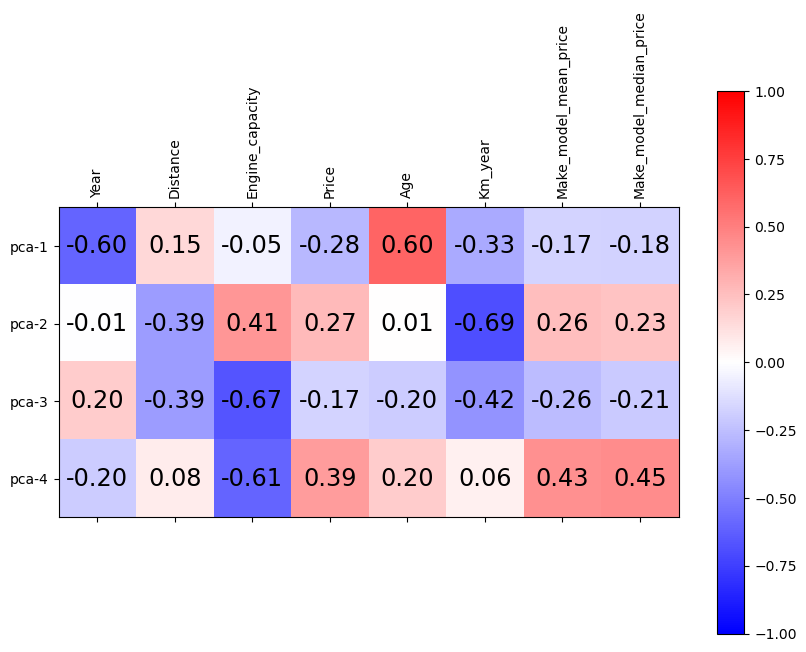

In [41]:
fig = plt.figure(figsize=(10, 7))

W = pca_car.components.T
pca_car_names = ['pca-' + str(x + 1) for x in range(W.shape[0])]

plt.matshow(W.astype(float), cmap='bwr', vmin=-1, vmax=1, fignum=1)

for (i, j), z in np.ndenumerate(W):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color='k', fontsize='xx-large')

plt.xticks(np.arange(0, W.shape[1]), car_df_number_norm.columns, rotation=90);
plt.yticks(np.arange(0, W.shape[0]), pca_car_names)
plt.colorbar();

### Применение пространства главных компонент в качестве входных данных для классификации

In [42]:
pca_car_sl = PCA_SL(n_components=4)

pca_car_sl.fit(X)
X_car_transform = pca_car_sl.transform(X)

car_df_pca = pd.DataFrame(X_car_transform, columns=pca_car_sl.get_feature_names_out())
car_df_pca.sample(5)

,pca0,pca1,pca2,pca3
15591,-0.362322,-0.001547,0.027166,0.018816
26740,-0.325599,0.087295,-0.146858,0.062107
19159,0.246002,-0.184212,0.064078,0.009572
28164,0.162340,-0.021955,-0.105458,-0.020513
4813,-0.341179,0.087408,-0.143929,0.022106


In [43]:
W = pca_car_sl.components_.T
pca_car_names_sl = ['pca-' + str(x) for x in range(W.shape[1])]

X_pca = car_df_pca.values
y_pca_true = car_df['Transmission'].cat.codes.values

logistic_regression = LogisticRegression(
    fit_intercept=True,
    penalty='l2',
    solver='saga',
    C=3,
    max_iter=100000
)

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca,
    y_pca_true,
    test_size=0.3,
    random_state=42
)

logistic_regression.fit(X_pca_train, y_pca_train);

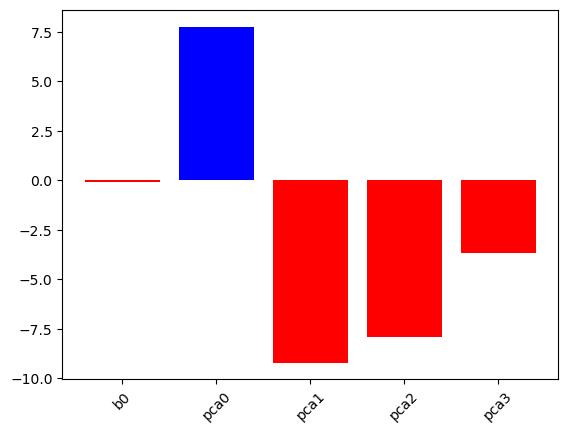

In [44]:
weights_vis(logistic_regression.coef_[0], logistic_regression.intercept_[0], car_df_pca.columns)

In [45]:
scoring = {'ACC': 'accuracy', 'F1': 'f1', 'Precision': 'precision', 'Recall': 'recall'}
           
scores = cross_validate(
    logistic_regression,
    X_pca_train,
    y_pca_train,
    scoring=scoring,
    cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
)

display(pd.DataFrame(scores))

,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,0.035999,0.005999,0.810577,0.829162,0.799301,0.861341
1,0.035013,0.006012,0.806516,0.826228,0.793271,0.862043
2,0.028975,0.005026,0.814360,0.830549,0.809592,0.852620
3,0.032998,0.005001,0.812349,0.830024,0.803244,0.858651
4,0.033028,0.004997,0.816774,0.835589,0.801593,0.872597


In [46]:
print(pd.DataFrame(scores).mean()[2:])

test_ACC          0.812115
test_F1           0.830310
test_Precision    0.801400
test_Recall       0.861450
dtype: float64


- Можно сделать вывод, что использование метода главных компонент, в данном случае при числе компонент равным 4, дает, примерно те же результаты, что и при использовании линейной регресии без уменьшения разменрности данных. 

# Кластеризация k-средних

## Синтетические данные

### Генерация данных

In [47]:
X_circle, y_circle = make_binary_clf(300, method='circles', noises=0.1)

### Визуализация данных

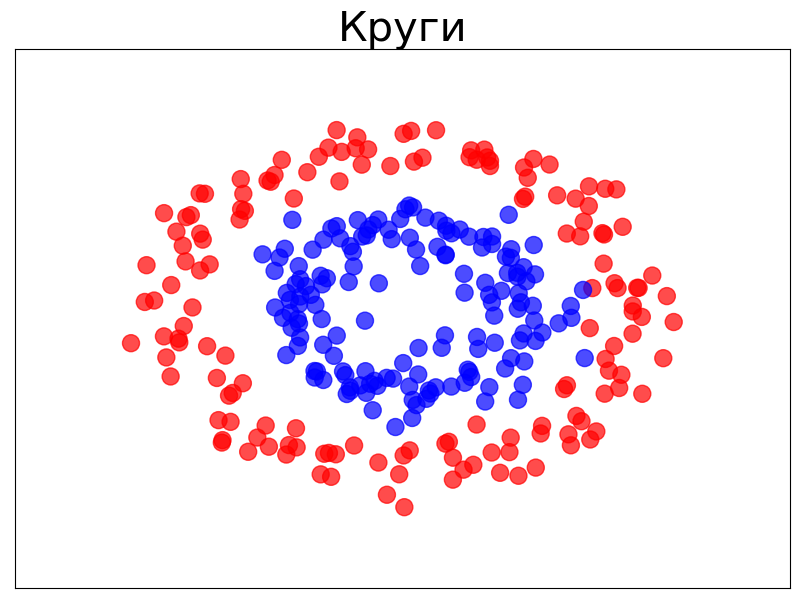

In [48]:
fig = plt.figure(figsize=(10, 7))

ax = plt.subplot(1, 1, 1)
plot_data(ax, (X_circle, y_circle), 'Круги')

In [49]:
for metric in ['euclidean', 'cityblock', 'Chebyshev', 'Minkowski']:
    print(distance(X_circle[0], X_circle[1], metric=metric, p=10))

1.0757278069509013
1.4651656733975011
0.9373205828475972
0.9376208068608946


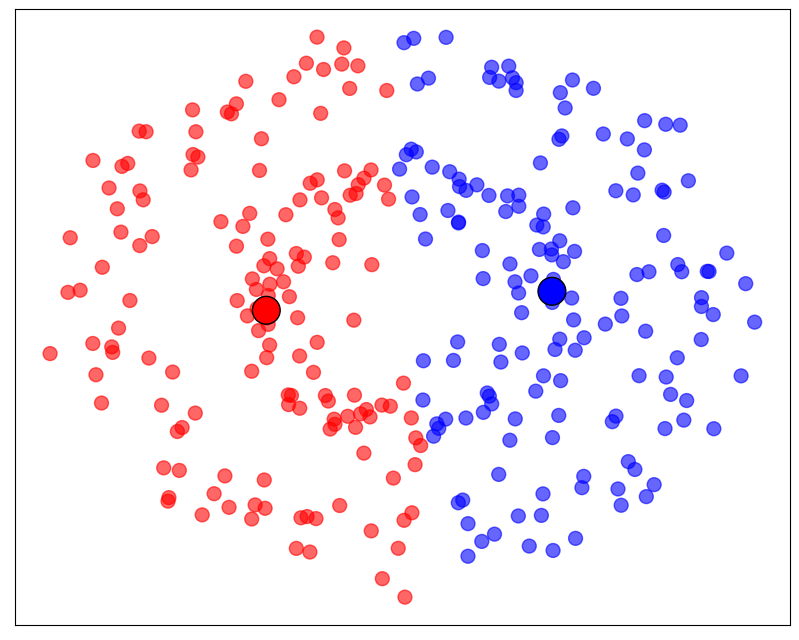

In [50]:
kmeans_circle = KMeans(n_clusters=2, max_iter=100, tol=0.01, random_state=42)
y_circle_labels = kmeans_circle.fit_transform(X_circle)

plot_cluster(X_circle, kmeans_circle.centroids, y_circle_labels, np.unique(y_circle_labels))

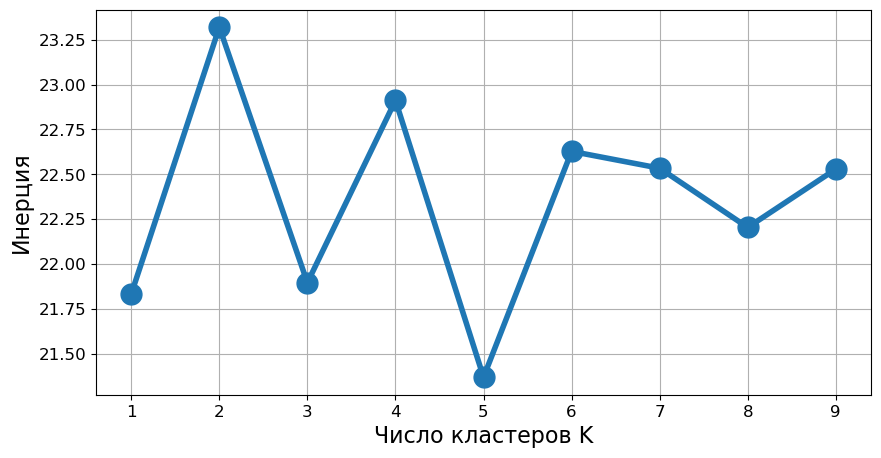

In [51]:
sse = []

list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=10)
    km.fit(X_circle)
    sse.append(km.inertia)

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o', linewidth=4, markersize=15)
plt.xlabel('Число кластеров K', fontsize=16)
plt.ylabel('Инерция', fontsize=16)

plt.grid();
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

- Судя по графику, оптимальное число кластеров равно 6

## Набор данных MNIST

### Загрузка данных

In [52]:
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=True)

X_mnist = X_mnist / 255.
X_mnist_values = X_mnist.values

In [53]:
pca_mnist_sl = PCA_SL(n_components=4)

pca_mnist_sl.fit(X_mnist_values)
X_mnist_pca_transform = pca_mnist_sl.transform(X_mnist_values)

In [54]:
X_mnist_pca_transform

array([[ 0.47943178, -1.24014024, -0.20063778, -2.18405936],
       [ 3.96272133, -1.13711891,  2.25924864, -1.9023051 ],
       [-0.23135659,  1.54391025, -0.63527999,  2.07541464],
       ...,
       [-1.06473337,  2.31403532,  1.33870489, -1.70588068],
       [-1.2165675 , -0.45774582,  2.49310282, -1.10780736],
       [ 4.15240054, -0.32702664,  2.86800644,  3.10213367]])

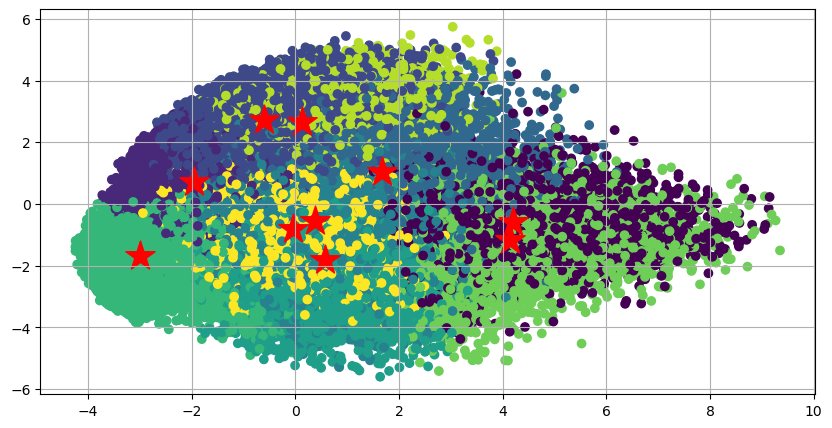

In [55]:
kmeans_mnist = KMeans_SL(n_clusters=10, max_iter=100, tol=0.01, random_state=42)
kmeans_mnist.fit(X_mnist_pca_transform)

centroids = kmeans_mnist.cluster_centers_

y_mnist_labels = kmeans_mnist.fit_predict(X_mnist_pca_transform)

plt.figure(figsize=(10, 5))
plt.scatter(X_mnist_pca_transform[:, 0], X_mnist_pca_transform[:, 1], c=y_mnist_labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=490)
plt.grid();

In [56]:
pd.crosstab(y_mnist, y_mnist_labels, rownames=['Метки'], colnames=['Предсказания'])

Предсказания,0,1,2,3,4,5,6,7,8,9
Метки,,,,,,,,,,
0,2630,25,10,302,271,281,7,2941,29,407
1,0,636,0,1,28,25,7157,0,2,28
2,309,434,21,419,3765,828,867,186,39,122
3,78,592,39,10,147,4486,204,349,82,1154
4,20,1247,1929,936,419,0,136,0,2106,31
5,68,397,314,39,352,1791,474,545,291,2042
6,174,175,3,2726,2964,52,527,90,3,162
7,3,1790,3315,39,78,4,231,4,1711,118
8,140,794,248,57,212,1580,474,356,233,2731


## Набор данных Car Moldova

### Загрузка данных

In [57]:
car_df = pd.read_csv('data/cars_moldova_data.csv', delimiter=',')
car_df.sample(5)

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price,Age,Km_year,Km_year_quantile,Make_model,Make_model_mean_price,Make_model_median_price
12340,BMW,X4,2017,Crossover,59764.0,1986.0,Petrol,Automatic,27999.0,5,11952.800000,Средний пробег,BMW X4,29886.750000,26099.5
23998,Mercedes,GL Class,2013,SUV,188408.0,2987.0,Diesel,Automatic,32000.0,9,20934.222222,Большой пробег,Mercedes GL Class,25105.354167,22950.0
21453,Mercedes,Series (W124),1987,Sedan,300000.0,2000.0,Diesel,Manual,2100.0,35,8571.428571,Небольшой пробег,Mercedes Series (W124),3189.603306,2600.0
27320,BMW,5 Series,2017,Sedan,130000.0,2000.0,Diesel,Automatic,28500.0,5,26000.000000,Большой пробег,BMW 5 Series,10450.374552,6825.0
13618,Audi,Allroad,2001,Universal,260000.0,2500.0,Diesel,Manual,5600.0,21,12380.952381,Средний пробег,Audi Allroad,8965.344828,6000.0


In [58]:
category_columns, number_columns = split_column_by_types(car_df)

print(category_columns)
print(number_columns)

['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'Km_year_quantile', 'Make_model']
['Year', 'Distance', 'Engine_capacity', 'Price', 'Age', 'Km_year', 'Make_model_mean_price', 'Make_model_median_price']


### Создадим набор данных только с числовыми признаками

In [59]:
car_df_number = car_df[number_columns].copy()
car_df_number.head(5)

,Year,Distance,Engine_capacity,Price,Age,Km_year,Make_model_mean_price,Make_model_median_price
0,2011,195000.0,1800.0,7750.0,11,17727.272727,8276.508621,7900.0
1,2014,135000.0,1500.0,8550.0,8,16875.000000,7177.654912,6999.0
2,2012,110000.0,1500.0,6550.0,10,11000.000000,4598.121951,5099.0
3,2006,200000.0,1600.0,4100.0,16,12500.000000,4488.550877,4300.0
4,2000,300000.0,2200.0,3490.0,22,13636.363636,8236.543333,7500.0


### Нормализация данных

In [60]:
car_df_number_norm = car_df_number.copy()

x_min = car_df_number_norm[number_columns].min()
x_max = car_df_number_norm[number_columns].max()

car_df_number_norm[number_columns] = (car_df_number_norm[number_columns] - x_min) / (x_max - x_min)

In [61]:
car_df_number_norm.sample(5)

,Year,Distance,Engine_capacity,Price,Age,Km_year,Make_model_mean_price,Make_model_median_price
31070,0.46,0.219922,0.291667,0.005912,0.54,0.155454,0.047108,0.014399
19447,0.74,0.249925,0.250000,0.018026,0.26,0.355855,0.027641,0.026539
3376,0.80,0.194919,0.416667,0.128246,0.20,0.353252,0.178989,0.176736
15739,0.64,0.122134,0.000000,0.030060,0.36,0.126909,0.019720,0.015246
31281,0.62,0.303930,0.333333,0.025551,0.38,0.302605,0.058688,0.045726


### Кластеризация методом k-средних

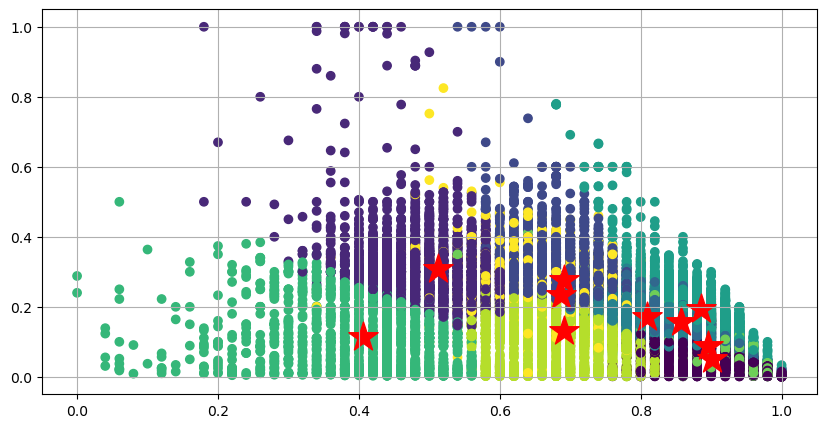

In [62]:
x_cars = car_df_number_norm.values

car_kmeans_sl = KMeans_SL(n_clusters=10)
car_kmeans_sl.fit(x_cars)

centroids = car_kmeans_sl.cluster_centers_

y_cars_labels = car_kmeans_sl.fit_predict(x_cars)

plt.figure(figsize=(10, 5))
plt.scatter(x_cars[:, 0], x_cars[:, 1], c=y_cars_labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=490)
plt.grid();

In [63]:
car_df['Transmission'] = car_df['Transmission'].astype('category')
y_true_labels = car_df['Transmission'].cat.codes.values

pd.crosstab(y_true_labels, y_cars_labels, rownames=['Метки'], colnames=['Предсказания'])

Предсказания,0,1,2,3,4,5,6,7,8,9
Метки,,,,,,,,,,
0,3051,400,1331,3156,2120,2071,109,1070,1049,2197
1,724,2577,3703,330,4952,1468,1435,12,3499,263


In [64]:
car_df['Fuel_type'] = car_df['Fuel_type'].astype('category')
y_true_labels = car_df['Fuel_type'].cat.codes.values

pd.crosstab(y_true_labels, y_cars_labels, rownames=['Метки'], colnames=['Предсказания'])

Предсказания,0,1,2,3,4,5,6,7,8,9
Метки,,,,,,,,,,
0,987,773,2994,2000,3703,2642,204,575,1531,1404
1,15,0,0,2,5,2,1,1,4,1
2,410,0,53,558,489,314,1,102,35,72
3,82,703,855,71,465,182,282,13,638,480
4,2164,1501,1132,694,2350,270,1056,365,2339,502
5,117,0,0,161,60,129,0,26,1,1


In [65]:
car_df['Style'] = car_df['Style'].astype('category')
y_true_labels = car_df['Style'].cat.codes.values

pd.crosstab(y_true_labels, y_cars_labels, rownames=['Метки'], colnames=['Предсказания'])

Предсказания,0,1,2,3,4,5,6,7,8,9
Метки,,,,,,,,,,
0,23,12,11,3,11,0,13,2,55,16
1,15,34,70,3,119,35,22,0,65,3
2,72,90,83,36,65,5,51,41,119,44
3,1119,20,297,1100,573,727,9,354,233,387
4,466,429,846,116,1793,375,283,16,1317,16
5,37,31,121,17,132,47,9,4,66,11
6,81,275,720,102,736,289,73,17,474,64
7,14,2,9,35,8,9,3,25,10,14
8,3,0,3,6,2,1,2,1,3,2
